# Career path

Mapping career paths at TRANSFORM 2020.

We'll use a 'vocab' so that everyone uses more or less the same words... we'll do some fuzzy matching so we don't end up with 'undergrad' and 'undergraduate' as separate things.

In [1]:
# Apart from academic, it's mostly 'where you work', not 'what you do'.
VOCAB = ["student", "undergrad", "postgrad", "postdoc", "lecturer", "professor", "reader", "academic",
         "megaservice", "service", "microservice",
         "consultant", "sales",
         "software", "technology",
         "noc", "ioc", "independent", "exploration", "e&p",
         "government", "agency", "localgov",
         "mining",
         "unemployed", "self-employed", "retired",
         "startup",
         "other"
        ]

Some made up data, including probably 'variants' (missing numbers, misspellings, no spaces, etc.).

The format is 'job' followed by a space then a number representing the number of years there. The records are separated by commas.

In [2]:
data = [
    "undergraduate 3, postgraduate 4, noc 3, software 4, consultant 1, ioc 5, microservice 10",
    "undergrd 4, independent 5, startup 5, software 3",
    "undergrad 3, service 3, postgrad 5, postdoc 3, ioc 5, professor 16, retired",
    "undergrad 3, postgrad, postdoc 3, noc 4, professor 20, retired",
    "undergrad 3, megaservice 5, software 3, unemployed 1, exploration 3, startup 1",
    "undergrad 3,postgrad 2,postgrad 4,software 3,unemployed 1,exploration 3,startup 1",
    "undergrad, postgrad, government,  mining, self-employed"
]

## Parse data

In [3]:
import difflib
from datetime import datetime

def store_entry(data):
    """
    In the webapp, we'll record every single response 'raw' so we can process later.
    """
    with open('log.txt', 'ta') as f:
        d = datetime.utcnow().isoformat() + '\t'
        f.write(d + data + '\n')
    return 'Done'

def get_path(record):
    """
    Take a single response and turn it into a list of careers.
    
    Completely ignore the numbers for now.
    """
    items = [tuple(i.strip().split()) for i in record.split(',')]
    path = []
    for pair in items:
        m, = difflib.get_close_matches(pair[0], VOCAB, n=1, cutoff=0)
        path.append(m)
    return path

In [4]:
# Just for the toy data.
paths = []
for record in data:
    store_entry(record)
    paths.append(get_path(record))

Use a Shelf:

In [5]:
import shelve

def store(path):
    with shelve.open('edges') as db:
        for pair in [*zip(path[:-1], path[1:])]:
            count = db.get(','.join(pair), 0)
            db[','.join(pair)] = count + 1
    return

In [10]:
for path in paths:
    store(path)

## Make network

In [11]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(VOCAB)

with shelve.open('edges') as db:
    for e, w in db.items():
        u, v = e.split(',')
        G.add_edge(u, v, weight=w)

G.remove_nodes_from(list(nx.isolates(G)))

## Viz

- network diagram of paths
- ribbons of time

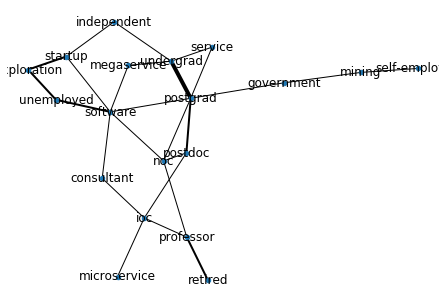

In [12]:
%matplotlib inline

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

params = {
    'node_size': 20,
    'with_labels': True,
    'width': weights,
}

pos = nx.spring_layout(G)

nx.draw(G, pos, **params)

## Ribbons